### IMPORTANT NOTE: 
We  notice that there are several inconsistencies in the data:<br>

**Example 1:** According to the description Justyce Kaseem Wright should be:<br>
**RAW TEXT:** <Unknown>/Wright, Justyce Kaseem<br>
**Normalized Text:** Justyce Kaseem Wright <br>

However in the data we find that: <br>
**RAW TEXT:** <Unknown>/Wright, Justyce Kaseem <br>
**Normalized Text:** Wright/Justyce Kaseem <br>

Additionally, in several cases common latin names are not parsed like for example:<br>
**Example 2:** In the data we find:<br>
**RAW TEXT:** Mendel Brikman<br>
**Normalized Text:**<br>

There are several such redundancies / issues throughout the the dataset. As such, we need to establish some conventions. For example, in our implementation we generally try to follow the labels, and separate when we find a comma ','. Additionally, based on most raw text cases, if we find latin character names with diacritics they pass our filter and are considered names. If however the names are not latin they are dropped. (Based on this convention Mendel Brikman should be included in the normalized text)

Additionally, potential inconsistencies can affect perceived performance. For instance, in Example 2,  including Mendel Brikman as Normalized Text would likely decrease the overall performance (compared to the baseline) even though we want this behaviour.

In [ ]:
import pandas as pd
from collections import Counter
import re


def split_keep_phrases_dynamic(text, separation='weak'):
    if not text or not isinstance(text, str):
        return []  # Return an empty list for invalid or empty input

    # Identify non-alphanumeric separators (escaping used for handling re symbols)
    if separation == 'strong':
        # More general separation using collection of separators
        separators = ''.join([re.escape(char) for char, _ in Counter(text).items() if not char.isalnum() and char.strip()])
    else:
        # Weaker separation based on the data
        separators_list = '/&,()' # Regarding commas we follow the convnetion on the CLEAN_TEXT labels and not of the example i.e., we separate the writer
        separators = ''.join([re.escape(char) for char in separators_list if not char.isalnum() and char.strip()])

    # Debugging: Log separators to ensure they're valid
    if not separators:
        print(f"No valid separators found in: {text}")
        return [text.strip()]  # Return the original text as a single phrase

    try:
        # Build regex to split on these separators (excluding spaces)
        regex = f"[{separators}]+"
        
        # Split the text while keeping phrases together
        parts = re.split(regex, text)
        return [part.strip() for part in parts if part.strip()]
    except re.error as e:
        # Log regex error for debugging
        print(f"Regex error with separators '{separators}' for text: {text}. Error: {e}")
        return [text.strip()]  # Return the original text as a fallback



# Read the  file
file_path = "data/raw/normalization_assesment_dataset_10k.csv"
df = pd.read_csv(file_path)

# Apply the splitting function to the 'raw_comp_writers_text' column
df['split_phrases'] = df['raw_comp_writers_text'].apply(lambda x: split_keep_phrases_dynamic(x,separation='weak') if pd.notnull(x) else [])

# Save the updated DataFrame to a new  file
output_file_path = "output_file.csv" 
df.to_csv(output_file_path, index=False)

print(f"Processed data has been saved to {output_file_path}")


Processed data has been saved to output_file_llm.csv


### Simple Preprocessing Steps

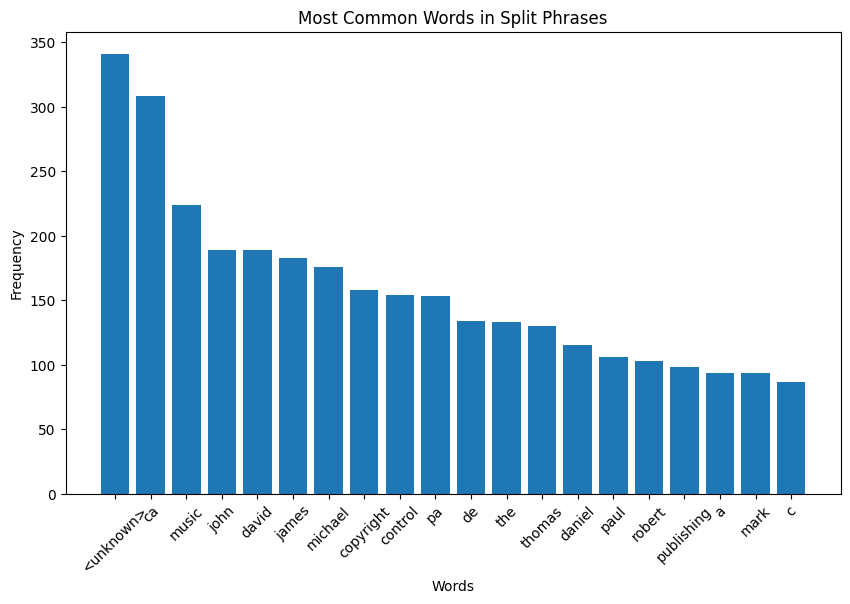

In [ ]:
import pandas as pd
from collections import Counter
import ast
import matplotlib.pyplot as plt

# Step 1: Read the CSV
df = pd.read_csv("output_file.csv") 

# Step 2: Convert strings of lists into actual lists
df["split_phrases"] = df["split_phrases"].apply(ast.literal_eval)

# Step 3: Flatten the lists of phrases into a single list of words
all_words = [word for phrases in df["split_phrases"] for phrase in phrases for word in phrase.lower().split()]

# Step 4: Count word frequencies
word_counts = Counter(all_words)

# Step 5: Get the most common words
most_common_words = word_counts.most_common(20)  # Top 10 most common words
words, counts = zip(*most_common_words)

# Step 6: Create a histogram
plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.title("Most Common Words in Split Phrases")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


In [131]:
# Example filtering keywords that indicate non-writer entities, based on manual inspection of the histogram of words:
NON_WRITER_KEYWORDS = [
    "unknown", "copyright", "control", "publishing", "music", "records",
    "ca","pa", "ltd", "universal", "warner", "sony", "ascap", "writer"
]


# Step 1: Read the CSV
df = pd.read_csv("output_file.csv")  
df["split_phrases"] = df["split_phrases"].apply(ast.literal_eval)

# Remove the non-name words from all phrases in 'split_phrases'
def remove_non_name_words(phrases):
    updated_phrases = []
    for phrase in phrases:
        filtered_phrase = " ".join(word for word in phrase.split() if word.lower() not in NON_WRITER_KEYWORDS)
        if filtered_phrase:  # Only add non-empty phrases
            updated_phrases.append(filtered_phrase)
    return updated_phrases

capital_diacritics = 'ÄÖÜÆØÅÉÈÊËÁÀÂÍÌÎÓÒÔÚÙÛÑÇÝŸŒĐŁØÙÃÕÑȘȚĂÎÂȚÁÓ'
lowercase_diacritics = 'äöüßæøåéèêëáàâíìîóòôúùûñçýÿœđłøùãõñșțăîâțáóảâấầậẵẽếệếặỉơợệớửựắấăằắằẳặẽẵảẻẻễđăếệêửươăặịảẵẩảứửắ'
special_chars = '@$'
regex_extended_latin=f"[^a-zA-Z0-9\\s.,;:'\"()\\[\\]!?\\-–—{capital_diacritics}{lowercase_diacritics}{special_chars}]+"
def keep_general_latin_and_punctuation_with_case(phrases, regex):
    """
    Keeps English characters, extended Latin-based characters (including uppercase),
    and common punctuation. Removes all other characters.

    Args:
        text (str): The input text.

    Returns:
        str: Cleaned text with Latin-based characters (uppercase and lowercase) and punctuation.
    """
    updated_phrases = []
    for phrase in phrases:
        updated_phrase = re.sub(regex, "", phrase)
        if updated_phrase:
            updated_phrases.append(updated_phrase)
    return updated_phrases

# Apply the function to the 'split_phrases' column
# We use apply for clarity and expecting it to be faster than for loop
df["preproc_phrases"] = df["split_phrases"].apply(lambda x: keep_general_latin_and_punctuation_with_case(x,regex_extended_latin) if x!=[] else [])
df["preproc_phrases"] = df["preproc_phrases"].apply(remove_non_name_words)



# Save the updated DataFrame to a new Excel file
output_file_path = "output_file_preproc.csv"  
df.to_csv(output_file_path, index=False)


# Check the updated DataFrame
print(df["preproc_phrases"].head())

0          [Jordan Riley, Adam Argyle, Martin Brammer]
1                                      [Martin Hygård]
2    [Jesse Robinson, Greg Phillips, Kishaun Bailey...
3                                     [Mendel Brikman]
4                                          [Alvin Lee]
Name: preproc_phrases, dtype: object


### NER: 

Use Spacy and perform Named entity recognition and identify names. With some leeway we drop phrases with no names

In [ ]:
import spacy
import time
import pandas as pd
import ast

# Load spaCy's English language model
spacy.require_gpu()
nlp = spacy.load("en_core_web_trf")


def filter_phrases_with_names_batch(phrases_list, r):
    results = []
    # Process all phrases in the list as a batch and keep enabled only the ner component, 
    # for efficient processing based on https://spacy.io/usage/processing-pipelines
    docs = list(nlp.pipe(phrases_list))  #disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]))  # Batch process phrases with spaCy
    for i, doc in enumerate(docs):
        phrase = phrases_list[i]
        words = phrase.split()
        num_words = len(words)
        
        # Count "PERSON" entities in the processed doc
        num_names = sum(1 for ent in doc.ents if ent.label_ == "PERSON")
        
        # Check if the percentage of names meets the threshold
        if num_words > 0 and (num_names / num_words) >= r[0]:
            results.append(phrase)
        else:
            num_nouns = sum(1 for token in doc if token.pos_ == "PROPN"  or token.pos_ == "NOUN" or token.pos_ == "ADJ" or token.pos_ == "INTJ")
            if num_words > 0 and (num_nouns / num_words) >= r[1]:
                results.append(phrase)
    return results


# Step 1: Read the CSV
df = pd.read_csv("output_file_preproc.csv") 
df["preproc_phrases"] = df["preproc_phrases"].apply(ast.literal_eval)


# Apply the function to the 'split_phrases' column
r = (0.5, 0.9)  # Replace with your desired percentage threshold (e.g., 50%)
start_time=time.time()
df["preproc_phrases_ner_1"] = df["preproc_phrases"].apply(lambda phrases: filter_phrases_with_names_batch(phrases, r))
print(time.time()-start_time)

# Save the updated DataFrame to a new Excel file
output_file_path = "output_file_ner.csv"  
df.to_csv(output_file_path, index=False)

# Check the updated DataFrame
print(df.head())


c:\Users\konni\venv\Lib\site-packages\thinc\shims\pytorch.py:261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filelike, map_location=devic

dropin 999990
dropin An Stepper
dropin PERF BY KALI
dropin fo man
dropin District 6
dropin GO TO THE BEDS
dropin A Day A Dream
dropin 0
dropin ZERO YVES
dropin Songs of
dropin Back on Track
dropin A GILMORE ROBERT B ROB
dropin PLOEGMAKERS MARTINUS A THIJS
dropin The Toy Hearts
dropin BMG BUMBLEBEE OBO ARSED
dropin KOBALT PUB AMERICA I OBO TALK STRETCH
dropin Adminstered by Songs of Kobalt
dropin Who Is That Man
dropin Adminstered by Songs of Kobalt
dropin Adminstered by Songs of Kobalt
dropin Rich the Kid
dropin THE CLERKS
dropin Dominator of Triple C
dropin Rich the Factor
dropin Nef The Pharaoh
dropin Royce da 59
dropin Destroy Lonely
dropin Kuma the Third
dropin 2021 Truth
dropin a division of Truth Limited
dropin 2020 TRUTH GROUP LIMITED
dropin 2020 TRUTH
dropin Loss Mad Vems
dropin Big Sad 1900
dropin Earthtone III
dropin Doble ONE Flow Letal
dropin Soldado 449 Ivan
dropin Just Creative 111
dropin -
dropin A.R. The Mermaid
dropin Alex Funk it
dropin 1685-1750
dropin Fadly RMX
drop

### LLama 3.1 - 8b (or another model) using  Groq (or another API service)

We can use a general purpose LLM through an API service to perform the task. This could be an expensive solution which could yield reliable results

We ll split our data into batches and apply the api call

In [ ]:
from groq import Groq



def extract_strings_w_keyword(message, keyword):
    """
    Extracts strings between a given keyword and the end of line or a parenthesis.

    Args:
        message (str): The large input message.
        keyword (str): The keyword to search for.

    Returns:
        list: A list of strings found between the keyword and the end of line or parenthesis.
    """
    # Build the regex pattern to match keyword followed by anything up to \n or '('
    pattern = rf"{re.escape(keyword)}(.*?)(\n|\(|###)"
    
    # Find all matches
    matches = re.findall(pattern, message)
    
    # Extract only the matched strings (group 1)
    return [match[0].strip() for match in matches]


df = pd.read_csv("output_file.csv")  
raw_df = df["raw_comp_writers_text"]
clean_df = df["CLEAN_TEXT"] 

client = Groq(api_key="",)
batch_size = 10 

preds_list,raw_list,clean_list=[],[],[]
# Example Sample of 4 batch sizes
for i in range(0, 4*batch_size, batch_size):
    raw_batch = raw_df.iloc[i:i+batch_size]
    clean_batch = clean_df.iloc[i:i+batch_size]
    s="\n".join([f"    RAW TEXT:{ph}" for ph in raw_batch])
    prompt = \
    f"""
    You are a useful linguist assistant. We want to perform text normalisation on names of songwriters. We will give you a string which includes names or nicknames 
    in different formats and containing potentially unecessary words you ll need to clean up - or maybe just the name or nickname. 
    Also some Raw text does not contain any useful information (e.g., unknown, weird initials, standardized words, etc)
    Do not include any outputs of non-latin (e.g., cyrillic, chinese or arabian) characters in your output. 
    If there are multiple names or nicknames separate with '/'. Also end your response with '###' so that i can easily find the end.
    You ll need to return the correct names.
    Some examples:
    Example1:
    RAW TEXT: <Unknown>/Wright, Justyce Kaseem
    Normalized Text: Justyce Kaseem Wright
    Example 2:
    RAW TEXT: Pixouu/Abdou Gambetta/Copyright Control
    Normalized Text: Pixouu/Abdou Gambetta
    Example 3:
    RAW TEXT: Mike Hoyer/JERRY CHESNUT/SONY/ATV MUSIC PUBLISHING (UK) LIMITED
    Normalized Text: JERRY CHESNUT/Mike Hoyer
    Example 4:
    RAW TEXT: 신중현 (Shin Joong Hyun)
    Normalized Text: Shin Joong Hyun
    Example 5:
    RAW TEXT: 신중현
    Normalized Text:
    Example 6:
    RAW TEXT: UNKNOWN 
    Normalized Text: 

    Perform the same for the following cases:
    {s}
    """
    
    chat_completion = client.chat.completions.create(messages=[{"role": "user","content": prompt, }],model="llama3-8b-8192",)
    output_msg = chat_completion.choices[0].message.content
    res = extract_strings_w_keyword(output_msg, "Normalized Text:")
    print(output_msg,res)
    
    raw_names = [ph for ph in raw_batch]
    clean_names = [ph for ph in clean_batch]

    preds_list.extend(res)
    raw_list.extend(raw_names)
    clean_list.extend(clean_names)



llm_df =  pd.DataFrame({
    "RAW_TEXT": raw_list,
    "CLEAN_TEXT": clean_list,
    "PRED_TEXT": preds_list
})


output_file_path = "output_file_llm.csv"  
llm_df.to_csv(output_file_path, index=False)
      




I'd be happy to help you with text normalization on songwriters' names! Here are the normalized outputs for each case:

RAW TEXT: Jordan Riley/Adam Argyle/Martin Brammer
Normalized Text: Jordan Riley/Adam Argyle/Martin Brammer ###

RAW TEXT: Martin Hygård
Normalized Text: Martin Hygård ###

RAW TEXT: Jesse Robinson/Greg Phillips/Kishaun Bailey/Kai Asa Savon Wright
Normalized Text: Jesse Robinson/Greg Phillips/Kishaun Bailey/Kai Asa Savon Wright ###

RAW TEXT: Mendel Brikman
Normalized Text: Mendel Brikman ###

RAW TEXT: Alvin Lee
Normalized Text: Alvin Lee ###

RAW TEXT: Haddag Samir/MusicAlligator
Normalized Text: Haddag Samir ###

RAW TEXT: Mefi Morales
Normalized Text: Mefi Morales ###

RAW TEXT: Christopher Franke
Normalized Text: Christopher Franke ###

RAW TEXT: UNKNOWN WRITER (999990)
Normalized Text: ###

RAW TEXT: Shashank Katkar
Normalized Text: Shashank Katkar ###

Let me know if you need any further assistance! ['Jordan Riley/Adam Argyle/Martin Brammer', 'Martin Hygård', 'J

### Custom DL Model (PyTorch)

Finally, we train a  Transformer encoder model to automatically perform normalisation. The model takes as input an raw string and  trains on the respective  CLEAN TEXT string as the target. We use character level tokenization, and the torch framework to train a small 4 layer encoder transformer on this task. We use cross entropy loss on an unembed (embed to vocab) layer to predict the appropriate  letters of the output based on the clean text. 

There is a lot room for improvement as we dont have a lot of data, or a lot of compute either to train or to evaluate. Apart from more data  and compute, we suspect that a better mapping between the input and output data would be beneficial (where potentially each letter maps if possible directly in input and output poisitions). 



In [113]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import random
import numpy as np
import pandas as pd

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Load the data
df = pd.read_csv("output_file.csv")  

# Split into train, val, test
train_df, val_df, test_df = np.split(df.sample(frac=1, random_state=42), 
                                     [int(0.8 * len(df)), int(0.9 * len(df))])

train_df["raw_comp_writers_text"] = train_df["raw_comp_writers_text"].fillna("").astype(str)
train_df["CLEAN_TEXT"] = train_df["CLEAN_TEXT"].fillna("").astype(str)

val_df["raw_comp_writers_text"] = val_df["raw_comp_writers_text"].fillna("").astype(str)
val_df["CLEAN_TEXT"] = val_df["CLEAN_TEXT"].fillna("").astype(str)

test_df["raw_comp_writers_text"] = test_df["raw_comp_writers_text"].fillna("").astype(str)
test_df["CLEAN_TEXT"] = test_df["CLEAN_TEXT"].fillna("").astype(str)

# Character-level vocabulary
chars = sorted(set("".join(train_df["raw_comp_writers_text"]) + "".join(train_df["CLEAN_TEXT"])))
char_to_idx = {ch: idx for idx, ch in enumerate(chars)}
idx_to_char = {idx: ch for ch, idx in char_to_idx.items()}
print(len(chars), chars)

# Tokenization
def tokenize(text, char_to_idx, max_len=100):
    tokenized = [char_to_idx[ch] for ch in text if ch in char_to_idx]
    return tokenized[:max_len] + [0] * (max_len - len(tokenized))

class TextDataset(Dataset):
    def __init__(self, df, char_to_idx, max_len=100):
        self.raw_texts = df["raw_comp_writers_text"].tolist()
        self.clean_texts = df["CLEAN_TEXT"].tolist()
        self.char_to_idx = char_to_idx
        self.max_len = max_len

    def __len__(self):
        return len(self.raw_texts)

    def __getitem__(self, idx):
        raw = tokenize(self.raw_texts[idx], self.char_to_idx, self.max_len)
        clean = tokenize(self.clean_texts[idx], self.char_to_idx, self.max_len)
        return torch.tensor(raw, dtype=torch.long), torch.tensor(clean, dtype=torch.long)

# Create datasets and dataloaders
max_len = 100
batch_size=32
train_dataset = TextDataset(train_df, char_to_idx, max_len)
val_dataset = TextDataset(val_df, char_to_idx, max_len)
test_dataset = TextDataset(test_df, char_to_idx, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Transformer Encoder Model
class TransformerEncoderModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, max_len):
        super(TransformerEncoderModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_len, embed_dim))
        # Default not causal, as we want in this case
        encoder_layer = nn.TransformerEncoderLayer(embed_dim, num_heads, ff_dim) 
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, src):
        embed = self.embedding(src) + self.positional_encoding[:, :src.size(1), :]
        encoded = self.transformer_encoder(embed)
        output = self.fc(encoded)
        return output

# Model configuration
vocab_size = len(chars)
embed_dim = 128
num_heads = 8
ff_dim = 512
num_layers = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:","cuda" if torch.cuda.is_available() else "cpu")
model = TransformerEncoderModel(vocab_size, embed_dim, num_heads, ff_dim, num_layers, max_len).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Training loop
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for raw, clean in dataloader:
        raw, clean = raw.to(device), clean.to(device)
        optimizer.zero_grad()
        output = model(raw)
        loss = criterion(output.view(-1, vocab_size), clean.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# Validation loop
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for raw, clean in dataloader:
            raw, clean = raw.to(device), clean.to(device)
            output = model(raw)
            loss = criterion(output.view(-1, vocab_size), clean.view(-1))
            total_loss += loss.item()
    return total_loss / len(dataloader)

# Training the model
epochs = 10
for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Save the model
torch.save(model.state_dict(), "transformer_encoder_model.pth")


c:\Users\konni\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\konni\venv\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


1060 [' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '\xa0', '«', '»', 'Á', 'Â', 'Ä', 'Å', 'É', 'Í', 'Ò', 'Ó', 'Ö', 'Ø', 'Ü', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'ï', 'ñ', 'ò', 'ó', 'ô', 'õ', 'ö', 'ø', 'ù', 'ú', 'ü', 'ý', 'ă', 'ą', 'ć', 'Č', 'č', 'Đ', 'đ', 'ě', 'ğ', 'Ģ', 'ĩ', 'ī', 'ı', 'Ł', 'ł', 'ń', 'ņ', 'ň', 'ř', 'Ş', 'ş', 'Š', 'š', 'ũ', 'ū', 'Ż', 'ž', 'Ə', 'ơ', 'ư', 'ə', '́', 'Α', 'Γ', 'Δ', 'Ε', 'Η', 'Θ', 'Ι', 'Κ', 'Λ', 'Μ', 'Ξ', 'Ο', 'Ρ', 'Σ', 'Τ', 'Υ', 'Ω', 'ά', 'α', 'γ', 'η', 'ι', 'κ', 'ν', 'ο', 'ρ', 'ς', 'τ', 'φ', 'χ', 'ύ', 'ώ', 'Є', 'І', 'А', '

Perform inference, and show predictions and targets:

In [114]:
# Validation inference function
def infer_on_validation_set(model, dataloader, idx_to_char, device, num_samples=10):
    model.eval()
    predictions = []
    with torch.no_grad():
        for raw, clean in dataloader:
            raw = raw.to(device)
            output = model(raw)
            # Get the most likely token at each position (move tensor back to cpu to perform numpy operations)
            pred = torch.argmax(output, dim=-1).cpu().numpy()
            raw = raw.cpu().numpy()
            clean = clean.cpu().numpy()
            # Decode and append
            for i in range(min(len(raw), num_samples)):
                raw_text = "".join(idx_to_char[idx] for idx in raw[i] if idx in idx_to_char)
                pred_text = "".join(idx_to_char[idx] for idx in pred[i] if idx in idx_to_char)
                clean_text = "".join(idx_to_char[idx] for idx in clean[i] if idx in idx_to_char)
                predictions.append((raw_text, pred_text, clean_text))
            if len(predictions) >= num_samples:
                break
    return predictions[:num_samples]

# Run inference on the validation set
num_samples_to_inspect = 10
validation_predictions = infer_on_validation_set(model, val_loader, idx_to_char, device, num_samples_to_inspect)

# Display the predictions
print(f"{'Raw Input':<50} | {'Predicted Output':<50} | {'Ground Truth':<50}")
print("=" * 150)
for raw_text, pred_text, clean_text in validation_predictions:
    print(f"{raw_text:<50} | {pred_text:<50} | {clean_text:<50}")


Raw Input                                          | Predicted Output                                   | Ground Truth                                      
Baker,Haarper                                                                                        | Baker/Haarper////////////////////////////////////////////////a////////////////////////a///////a///// | Baker/Haarper                                                                                       
Nawrras Music                                                                                        | Nawrras/Music////////////////////////////////////////////////a////////////////////////a///////a///// | Nawrras Music                                                                                       
CA DJ BUDDHA/CA HUNTE ANGELA ANN/CA KENZO EDDY/CA PERALTA CARLO/CA PHILLIP ANDREW/PA MAFFIO & ANGELA | CAADJ/BUDDHA/CA/HUNTE/ANGELA/ANN/CA/KENZO/EDDY/CA/PERALTA/CARLO/CA/PHILLIP/ANDREW/PA/MAFFIO/h/ANGELA | DJ BUDDHA/HUNTE ANGELA 

## Metrics: 



### Evaluation: 

We compare the full sets of predicted and reference phrases, labeling items as 1 (present) or 0 (not present) for each set, and then computing standard classification metrics like accuracy, precision, recall, and F1-score.

In [191]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.metrics import edit_distance


# Function to split CLEAN_TEXT by '/' based on labeling convention
def split_text(text):
    if not text or not isinstance(text, str):
        return []  # Handle empty or invalid inputs
    return [part.strip() for part in text.split('/') if part.strip()]

# Function to calculate BLEU score with special handling for single-token cases
def calculate_bleu(reference, predicted):
    smoothing_fn = SmoothingFunction().method1

    # If only one token, use a simple string comparison (only 2-gram+ in the implementation from nltk)
    if len(reference) == 1 and len(predicted) == 1:
        return 1.0 if reference[0] == predicted[0] else 0.0

    # Otherwise, compute BLEU score normally
    return sentence_bleu([reference], predicted, weights=(0.5, 0.5), smoothing_function=smoothing_fn)


# Function to calculate metrics per row
def calculate_metrics(row):
    # Extract the reference and predicted sets
    reference = set(split_text(row['CLEAN_TEXT']))
    pred_phrases_list = ast.literal_eval(row['preproc_phrases_ner_1'])  # Convert to list
    predicted = set(pred_phrases_list)    
    # Combine all unique phrases
    all_phrases = list(reference | predicted)
    
    # Create binary labels for reference and predicted
    reference_labels = [1 if phrase in reference else 0 for phrase in all_phrases]
    predicted_labels = [1 if phrase in predicted else 0 for phrase in all_phrases]
    
    # Compute edit distance and BLEU score
    edit_dist = edit_distance(' '.join(reference), ' '.join(predicted))
    bleu = calculate_bleu(list(reference), list(predicted))
    #print(reference,predicted, edit_dist, bleu)
    # Return the metrics
    return reference_labels, predicted_labels, all_phrases, edit_dist, bleu


# Load the processed CSV
file_path = "output_file_ner.csv"  
df = pd.read_csv(file_path)

# Apply metrics calculation to each row
metrics = df.apply(calculate_metrics, axis=1)

# Flatten the results for global metrics computation
reference_labels = []
predicted_labels = []
all_phrases = []
edit_distances = []
bleu_scores = []

for ref, pred, phrases, edit_dist, bleu in metrics:
    reference_labels.extend(ref)
    predicted_labels.extend(pred)
    all_phrases.extend(phrases)
    edit_distances.append(edit_dist)
    bleu_scores.append(bleu)

# Calculate overall metrics
precision = precision_score(reference_labels, predicted_labels, zero_division=0)
recall = recall_score(reference_labels, predicted_labels, zero_division=0)
f1 = f1_score(reference_labels, predicted_labels, zero_division=0)

# Logging also the accuracy and CM for completion, though the accuracy should  not be very indicative in this task
accuracy = accuracy_score(reference_labels, predicted_labels)
cm = confusion_matrix(reference_labels, predicted_labels) # Expected 0 predicted and true negatives

# Calculate overall average metrics
avg_edit_distance = sum(edit_distances) / len(edit_distances)
avg_bleu_score = sum(bleu_scores) / len(bleu_scores)

# Print overall metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Average Edit Distance: {avg_edit_distance:.2f}")
print(f"Average BLEU Score: {avg_bleu_score:.2f}")

# Save detailed results for debugging (optional)
output_with_details = "output_with_details.csv"
df['reference_labels'] = [ref for ref, _, _, _, _ in metrics]
df['predicted_labels'] = [pred for _, pred, _, _, _ in metrics]
df['all_phrases'] = [phrases for _, _, phrases, _, _ in metrics]
df['edit_distance'] = edit_distances
df['bleu_score'] = bleu_scores
df.to_csv(output_with_details, index=False)
print(f"Detailed results with edit distance and BLEU score have been saved to {output_with_details}")


Accuracy: 70.73%
Precision: 80.27%
Recall: 85.60%
F1 Score: 82.85%
Average Edit Distance: 5.04
Average BLEU Score: 0.76
Detailed results with edit distance and BLEU score have been saved to output_with_details.csv



**Strong Separation:**
Accuracy: 57.91% 
Precision: 65.99%
Recall: 82.54%
F1 Score: 73.34%
Average Edit Distance: 7.24
Average BLEU Score: 0.70

**Weal Separation:**
Accuracy: 67.63%
Precision: 74.86%
Recall: 87.51%
F1 Score: 80.69%
Average Edit Distance: 6.37
Average BLEU Score: 0.76

**Rule based** (simple preproc):
Accuracy: 70.80%
Precision: 79.14%
Recall: 87.05%
F1 Score: 82.91%
Average Edit Distance: 4.89
Average BLEU Score: 0.78 

**NER:** r=0.5:
Accuracy: 60.06%
Precision: 86.00%
Recall: 66.57%
F1 Score: 75.05%
Average Edit Distance: 9.54
Average BLEU Score: 0.56

**NER:** r=0.25
Accuracy: 68.57%
Precision: 83.93%
Recall: 78.94%
F1 Score: 81.36%
Average Edit Distance: 5.57
Average BLEU Score: 0.70

**NER & POS** r=(0.25,0.25):
ccuracy: 70.94%
Precision: 79.45%
Recall: 86.89%
F1 Score: 83.00%
Average Edit Distance: 4.86
Average BLEU Score: 0.77

**NER & POS** r=(0.25,0.9):
Accuracy: 70.60%
Precision: 80.22%
Recall: 85.48%
F1 Score: 82.76%
Average Edit Distance: 4.93
Average BLEU Score: 0.76

**NER & POS** r=(0.5,0.9):
Accuracy: 70.73%
Precision: 80.27%
Recall: 85.60%
F1 Score: 82.85%
Average Edit Distance: 5.04
Average BLEU Score: 0.76



**LLM** (llama-3.1-8B) (Small sample, **not full result!**):
Accuracy: 79.31%
Precision: 88.46%
Recall: 88.46%
F1 Score: 88.46%
Average Edit Distance: 2.40
Average BLEU Score: 0.73

Note: If we want to run things faster we maybe need to swithch to numpy. Also blue and edit distance calculations during evaluation are inefficient.